# TP3 - SVM
### Estudiante: Francisco Javier Piqueras Martínez
### Ejercicio de Regresión de los datos AirBnb

Pasos:
- 1. Estudio estadístico de las variables price, minimum_nights y calculated_host_listing_counts y realizar limpieza de datos
- 2. Regresión sobre el campo price usando SVR y LinearSVR para el modelo con neighbourhood y sin el.
- 3. Afinación con de hiperparámetros
- 4. Resultado

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import confusion_matrix, mean_squared_error

import matplotlib.pyplot as plt

In [3]:
airbnb_data = pd.read_csv(os.path.join("data","airbnb.csv"))

In [4]:
airbnb_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


### 1. Estudio estadístico y limpieza de datos

En primer lugar observamos los distintos valores de las variable `minumum_nights`, `price`y `calculated_host_listing_counts`para ver los outliers y eliminarlos

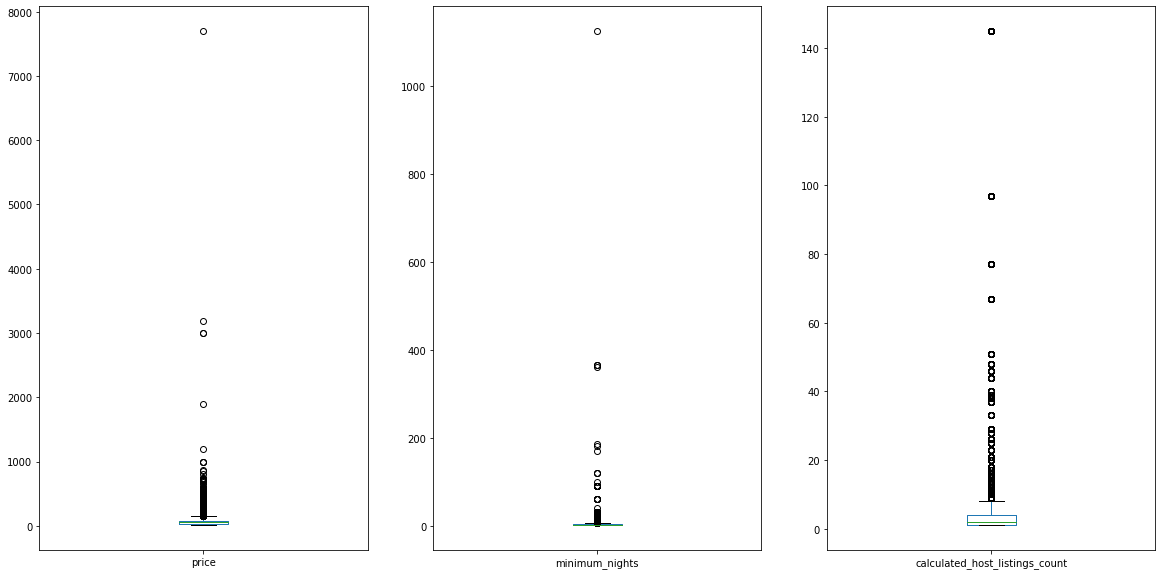

In [5]:
airbnb_study_data = airbnb_data[['price', 'minimum_nights', 'calculated_host_listings_count']]
airbnb_study_data.plot(kind="box", subplots=True, sharex=False, sharey=False,figsize=(20,10))
plt.show()

Como podemos observar, hay algún outlier en ellos. Tenemos que eliminar estos registros.

En primer lugar, `calculated_host_listings_count`


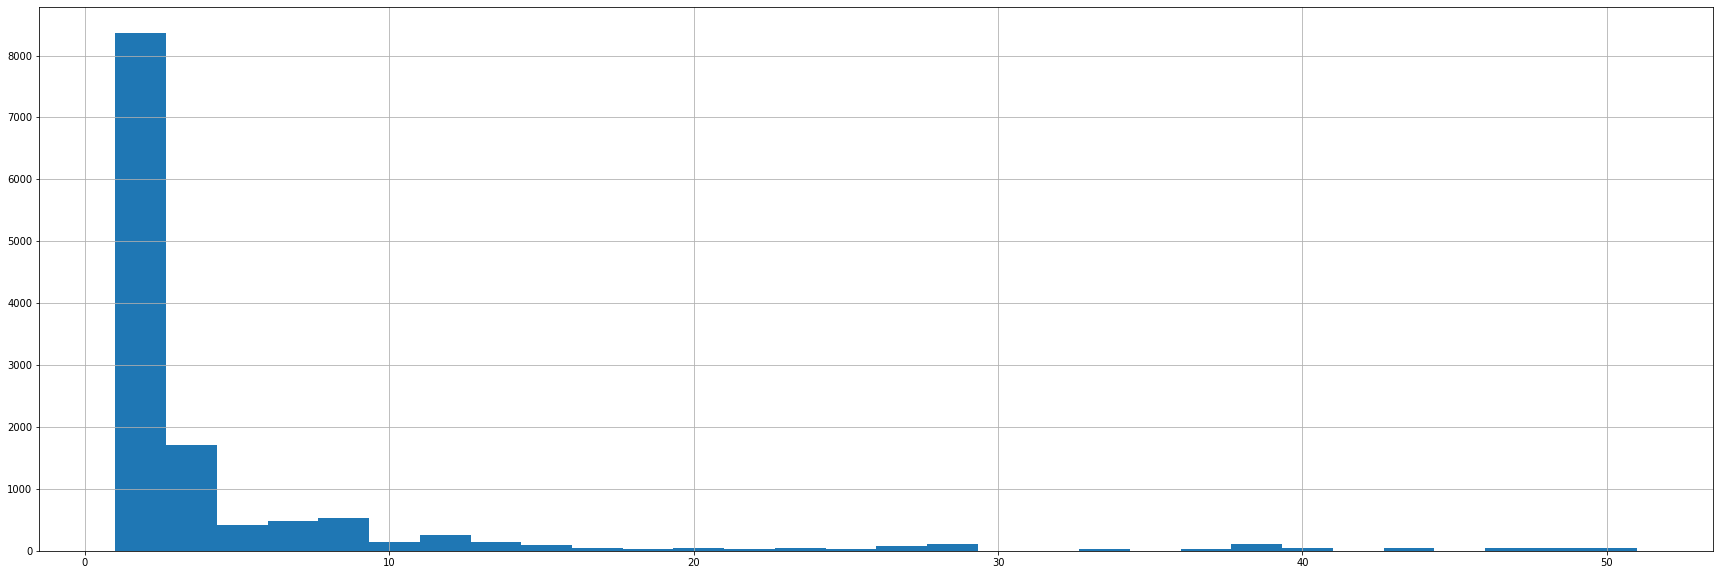

In [6]:
calculated_host_listings_count_airbnb = airbnb_study_data['calculated_host_listings_count']
calculated_host_listings_count_airbnb[calculated_host_listings_count_airbnb < 60].hist(bins=30, figsize=(30,10))

In [7]:
airbnb_data = airbnb_data[airbnb_data['calculated_host_listings_count'] < 60]

Seguidamente, `minimum_nights`:

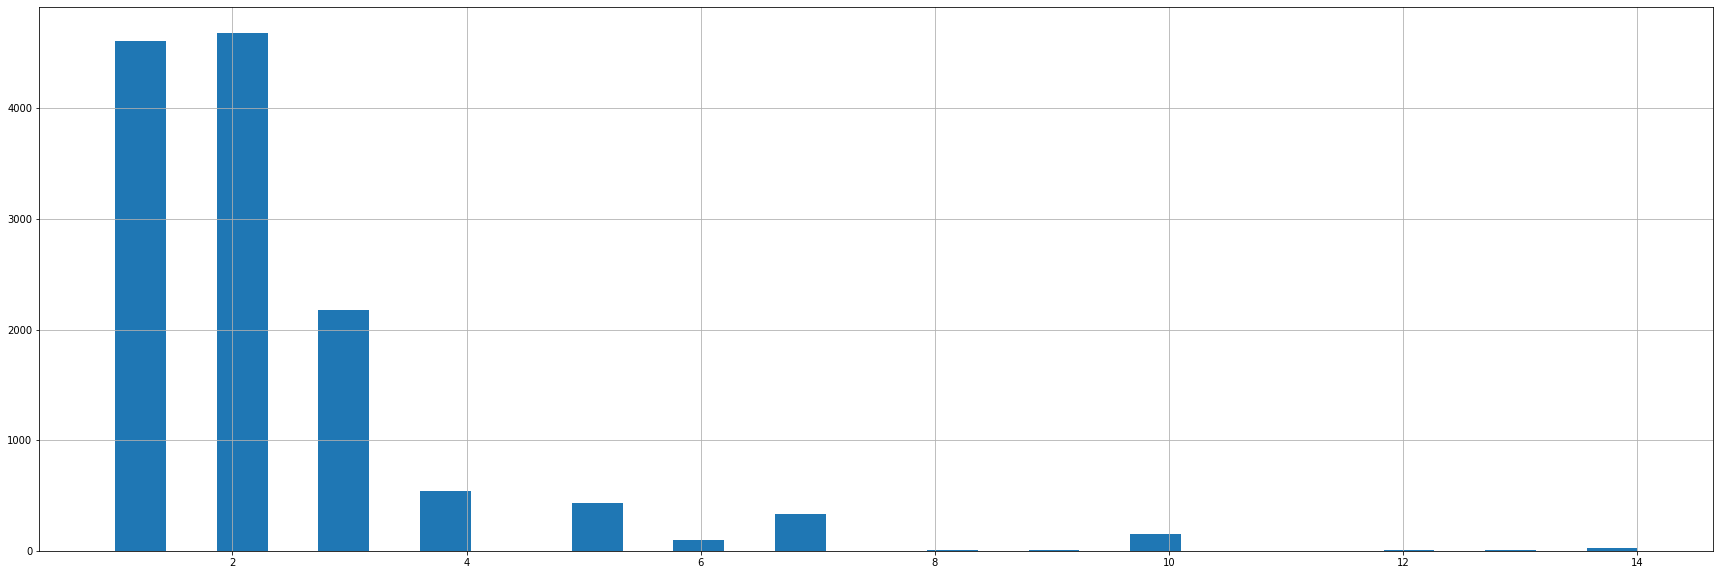

In [8]:
minimum_nights_airbnb = airbnb_study_data['minimum_nights']
minimum_nights_airbnb[minimum_nights_airbnb < 15].hist(bins=30, figsize=(30,10))

In [9]:
airbnb_data = airbnb_data[airbnb_data['minimum_nights'] < 15]

Finalmente, `price`:

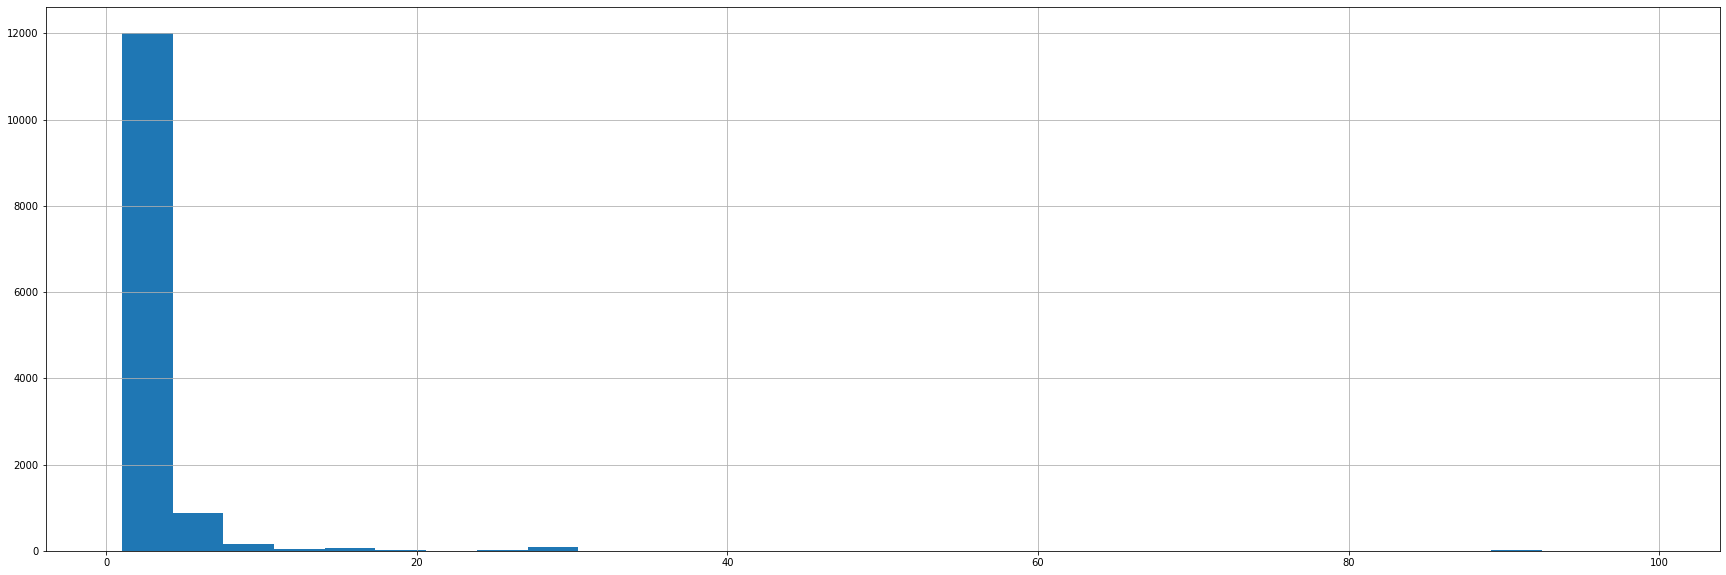

In [10]:
price_airbnb = airbnb_study_data['minimum_nights']
price_airbnb[price_airbnb < 100].hist(bins=30, figsize=(30,10))

In [11]:
airbnb_data = airbnb_data[airbnb_data['price'] < 100]

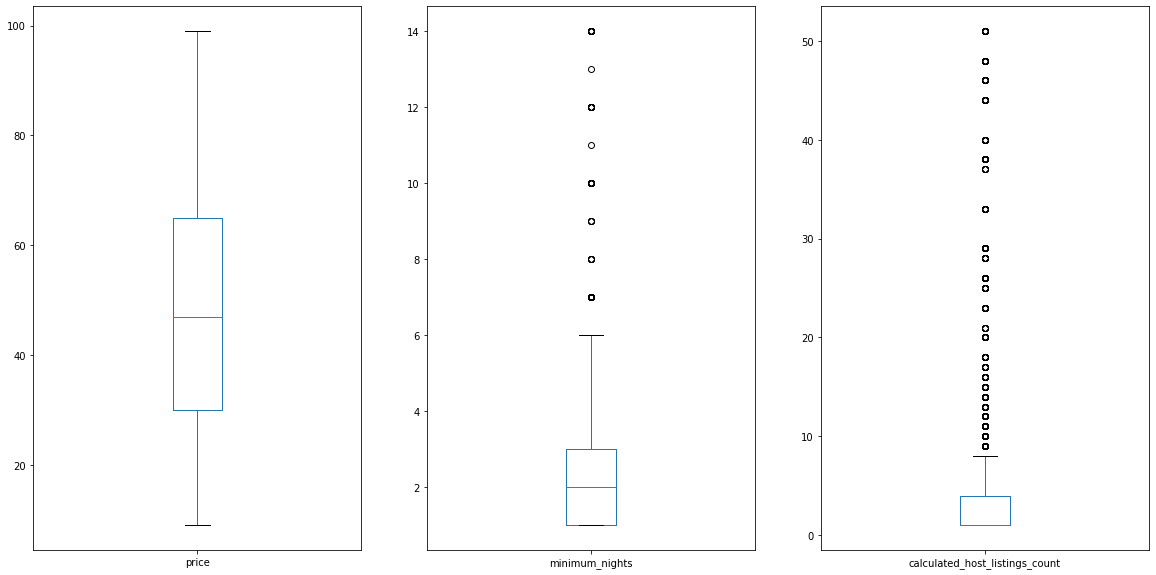

In [12]:
airbnb_study_data = airbnb_data[['price', 'minimum_nights', 'calculated_host_listings_count']]
airbnb_study_data.plot(kind="box", subplots=True, sharex=False, sharey=False,figsize=(20,10))
plt.show()

In [13]:
airbnb = airbnb_data.reset_index(drop=True)

In [14]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 11 columns):
neighbourhood_group               10842 non-null object
neighbourhood                     10842 non-null object
latitude                          10842 non-null float64
longitude                         10842 non-null float64
room_type                         10842 non-null object
price                             10842 non-null int64
minimum_nights                    10842 non-null int64
number_of_reviews                 10842 non-null int64
reviews_per_month                 10842 non-null float64
calculated_host_listings_count    10842 non-null int64
availability_365                  10842 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 931.9+ KB


Como se puede observar, todas las variables tienen 10842, por lo que no hay ningún valor faltante.

A continuación, separamos el dataset creando el training set (80%) y el text set (20%):

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=38)

for id_train, id_test in split.split(airbnb, airbnb["room_type"]):
    train_set, test_set = airbnb.loc[id_train], airbnb.loc[id_test]

y_train = train_set["price"]
X_train = train_set.drop("price", 1, inplace=False) 
y_test = test_set["price"]
X_test = test_set.drop("price", 1, inplace=False)

### 2. Regresion sobre `price` con y sin neighbourhood

In [16]:
airbnb_label = ["price"]
airbnb_categorical_yes = ["neighbourhood_group", "neighbourhood", "room_type"]
airbnb_categorical_no = ["neighbourhood_group", "room_type"]
airbnb_numerical = ["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]


airbnb_col_transformer_yes = ColumnTransformer([
    ("num_parser", StandardScaler(), airbnb_numerical),
    ("cat_parser", OneHotEncoder(handle_unknown='ignore'), airbnb_categorical_yes)
])

airbnb_col_transformer_no = ColumnTransformer([
    ("num_parser", StandardScaler(), airbnb_numerical),
    ("cat_parser", OneHotEncoder(handle_unknown='ignore'), airbnb_categorical_no)
])

In [17]:
airbnb_train_pipeline_linearsvr_yes = Pipeline([
    ("col_transformer", airbnb_col_transformer_yes),
    ("train", LinearSVR())
])

airbnb_train_pipeline_linearsvr_no = Pipeline([
    ("col_transforner", airbnb_col_transformer_no),
    ("train", LinearSVR())
])

airbnb_train_pipeline_svr_yes = Pipeline([
    ("col_transformer", airbnb_col_transformer_yes),
    ("train", SVR())
])

airbnb_train_pipeline_svr_no = Pipeline([
    ("col_transforner", airbnb_col_transformer_no),
    ("train", SVR())
])


#### Sin neighbourhood

In [18]:
airbnb_train_pipeline_linearsvr_no_score = cross_val_score(airbnb_train_pipeline_linearsvr_no, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=1)
airbnb_train_pipeline_linearsvr_no_score

array([-235.02044339, -233.58785049, -218.81490654, -220.37290023,
       -227.65418306])

In [19]:
airbnb_train_pipeline_svr_no_score = cross_val_score(airbnb_train_pipeline_svr_no, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=1)
airbnb_train_pipeline_svr_no_score

array([-247.88525753, -245.30153455, -232.43189451, -236.11942927,
       -234.43935035])

#### Con neighbourhood

In [20]:
airbnb_train_pipeline_linearsvr_yes_score = cross_val_score(airbnb_train_pipeline_linearsvr_yes, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=1)
airbnb_train_pipeline_linearsvr_yes_score

array([-229.86354343, -222.10987371, -209.03579445, -207.74022834,
       -216.41074419])

In [21]:
airbnb_train_pipeline_svr_yes_score = cross_val_score(airbnb_train_pipeline_svr_yes, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=1)
airbnb_train_pipeline_svr_yes_score

array([-273.32069696, -269.21756691, -258.52772021, -264.60910971,
       -255.59580621])

## 3. Afinamiento de los hiperparámetros

#### LinearSVR

Vamos a buscar los mejores valores c para nuestro modelo.

Para ello, vamos a realizar las tres búsquedas, una más abierta, y luego cada vez una reducida en la zona de mejores resultados para afinar los hiperparámetros.

In [22]:
airbnb_train_pipeline_linearsvr_yes.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'col_transformer', 'train', 'col_transformer__n_jobs', 'col_transformer__remainder', 'col_transformer__sparse_threshold', 'col_transformer__transformer_weights', 'col_transformer__transformers', 'col_transformer__verbose', 'col_transformer__num_parser', 'col_transformer__cat_parser', 'col_transformer__num_parser__copy', 'col_transformer__num_parser__with_mean', 'col_transformer__num_parser__with_std', 'col_transformer__cat_parser__categorical_features', 'col_transformer__cat_parser__categories', 'col_transformer__cat_parser__drop', 'col_transformer__cat_parser__dtype', 'col_transformer__cat_parser__handle_unknown', 'col_transformer__cat_parser__n_values', 'col_transformer__cat_parser__sparse', 'train__C', 'train__dual', 'train__epsilon', 'train__fit_intercept', 'train__intercept_scaling', 'train__loss', 'train__max_iter', 'train__random_state', 'train__tol', 'train__verbose'])

In [23]:
grid_first_params = {
    'train__C' : np.logspace(-5, 15, base=2, num=5)
}

grid_first_search = GridSearchCV(airbnb_train_pipeline_linearsvr_yes, grid_first_params, cv=5, n_jobs=-1)

grid_first_result = grid_first_search.fit(X_train, y_train)

In [24]:
grid_first_result.best_params_

{'train__C': 1.0}

In [25]:
grid_second_params = {
    'train__C' : np.logspace(-1, 1, base=2, num=5)
}

grid_second_search = GridSearchCV(airbnb_train_pipeline_linearsvr_yes, grid_second_params, cv=5, n_jobs=1)

grid_second_result = grid_second_search.fit(X_train, y_train)

In [26]:
grid_second_result.best_params_

{'train__C': 1.0}

In [27]:
grid_third_params = {
    'train__C' : np.logspace(-0.5, 0.5, base=2, num=5)
}

grid_third_search = GridSearchCV(airbnb_train_pipeline_linearsvr_yes, grid_second_params, cv=5, n_jobs=1)

grid_third_result = grid_second_search.fit(X_train, y_train)

In [28]:
grid_third_result.best_params_

{'train__C': 1.0}

In [29]:
airbnb_best_c_svr = grid_third_result.best_params_['train__C']

### 4. Resultado

Finalmente, creamos nuestro modelo con los hiperparámetros que hemos obtenido y vemos los resultados obtenidos:

In [30]:
y_test

8617    22
4611    60
3579    12
8225    20
1705    45
        ..
9002    39
3115    62
3374    65
9481    13
2338    18
Name: price, Length: 2169, dtype: int64

In [31]:
airbnb_train_pipeline_svr = Pipeline([
    ("col_transformer", airbnb_col_transformer_yes),
    ("test", LinearSVR(C=airbnb_best_c_svr))
])

In [32]:
airbnb_train_pipeline_svr.fit(X_train, y_train)
airbnb_train_pipeline_svr_prediction = airbnb_train_pipeline_svr.predict(X_test)

In [33]:
mean_squared_error(y_test, airbnb_train_pipeline_svr_prediction)

211.38409640437197